<a id='TableOfContents'></a>

# Notes:
1. Run each cell that has  **Run this cell as is**
2. Other code cells contain guides text and the expected output had left intentionally  to guide your development 
    * you need to work on lines contain this comment **# complete the code here**
    * or multi-line code when this comment is present:  **# write your code here**
3. In case your results are not matching the previous output (left for you) this could be due to randomization and you should not worry about them
4. Most of the code is ready,  all you need to do is to fill in some parts of the codes to complete

# Load Libraries

In [1]:
# load required libraries
# Run this cell as is

# models
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier

# dataset
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.datasets import load_breast_cancer

# evaluation metrics
from sklearn.metrics  import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score,\
                            ConfusionMatrixDisplay, classification_report


# preprocessing module and model selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler     
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split,  KFold, GroupKFold, GridSearchCV

# Matrices and Data structures
import pandas as pd
import numpy as np

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d


from sklearn import metrics

# other
from sklearn.base import TransformerMixin
import time
import pickle
import random

***************************************************

# Datasets part

## Fruits Dataset 

https://www.kaggle.com/datasets/mjamilmoughal/fruits-with-colors-dataset

In [2]:
# Run this cell as is
# load the dataset
dataraw = pd.read_csv('Data/fruit_data_with_colors.csv')

# check the data basic stats
dataraw.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


In [3]:
# the data has other information as fruit name or subtype
# let us drop them and keep them in another var - data

# Run this cell as is
data = dataraw.drop(['fruit_name', 'fruit_subtype'], axis=1)

In [4]:
# let us split the data into train and test

# Run this cell as is
# keep 20% for testing
fruit_X_train, fruit_X_test, fruit_y_train, fruit_y_test = train_test_split(data.iloc[:,1:],data.iloc[:,0],
                                                    test_size=0.2, stratify = data.iloc[:,0], random_state=2)


**Remember:** Testing data must not be used in model development! We need to use it later in the evaluation stage only

## Generated datasets


In [5]:
# Run this cell as is

# Blobs: make some training data
Xbtr, ybtr = make_blobs(n_samples=50, n_features=2, centers=[[1,1], [3,3]], cluster_std=0.5, random_state=20)
# make some validation data
Xbts, ybts = make_blobs(n_samples=20, n_features=2,centers=[[1,1], [3,3]], cluster_std=0.5, random_state=2 )
# Moons: make some training data
Xntr, yntr = make_moons(n_samples=50,random_state=20,noise =0.2)
# make some validation data
Xnts, ynts = make_moons(n_samples=20, random_state=2,noise =0.2)
#Circles: make some training data
Xctr, yctr = make_circles(n_samples=50,random_state=20,factor=0.6,noise = 0.1)
# make some validation data
Xcts, ycts = make_circles(n_samples=20,random_state=2,factor=0.6,noise = 0.1)

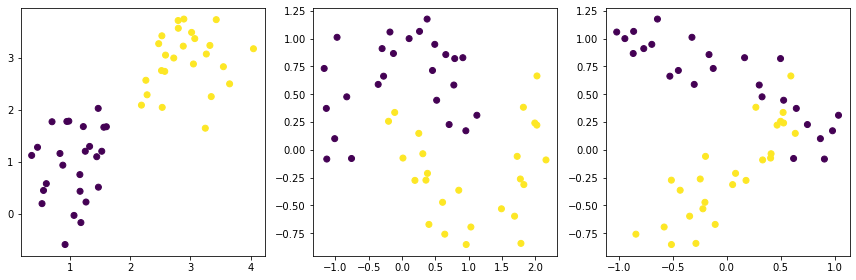

In [6]:
# Run this cell as is
# Check out and visualize the datasets
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(Xbtr[:,0],Xbtr[:,1], c= ybtr)
plt.subplot(1,3,2)
plt.scatter(Xntr[:,0],Xntr[:,1], c= yntr)
plt.subplot(1,3,3)
plt.scatter(Xctr[:,0],Xntr[:,1] , c= yctr)
plt.tight_layout()
plt.show()

# Function Definitions

In [7]:
# Run this cell as is
# custom transformation
class GaussianTransformation(TransformerMixin):
    transformed_data = None
    def __init__(self):
        self.transformed_data = [] 
    
    def fit(self, X, y=None):
        return self
    
    # let us define our Guassian transformation becuase it fits circle datasets
    def transform(self, X, y=None):
        X_ = X.copy()
        r =  np.exp(-(X_ **2).sum(1))
        X_ = np.hstack((X_, r.reshape(-1,1)))
        self.transformed_data = X_
        return X_


In [8]:
# Run this cell as is
# plot 3d data (transformed data)
def plot_3D(X, y,kerX, elev=30, azim=30):
    plt.figure(figsize=[8,5])  
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], kerX, c = y, s=50, cmap = 'flare')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1', fontsize=15)
    ax.set_ylabel('X2', fontsize=15)
    ax.set_zlabel('Z', fontsize=15)
    
    # Show data with various classes
def ScatterPlot(X, y):
    lbls = set(y)
    marker = ['o', '^', 'p', 'P', 'H', 'h', 'D', 'd']
    for i in lbls:
        plt.scatter(X[y==i,0], X[y==i,1], s=100, marker=marker[i], label = ('Objects:'+ str(i)) )
    plt.legend(loc=4) # lower right

### Plot Decisison Space Function

In [9]:
# Run this cell as is
# not working with all models, only models that compute probabilities can be used!
def plot_decisison (X,y, model , TestType='Training'):
    plt.figure(figsize=(9.8,5), dpi=100)
    
    for i, plot_type in enumerate(['Decision Boundary', 'Decision Probabilities']):
        plt.subplot(1,2,i+1)
        mesh_step_size = 0.01  # step size in the mesh
        x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
        y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
        if i == 0:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            try:
                Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
            except:
                plt.text(0.4, 0.5, 'Probabilities Unavailable', horizontalalignment='center',
                     verticalalignment='center', transform = plt.gca().transAxes, fontsize=12)
                plt.axis('off')
                break
        Z = Z.reshape(xx.shape)
        lbls = set(y)
        for i in lbls:
            plt.scatter(X[y==i,0], X[y==i,1], alpha=0.4, s=5, cmap='magma')#RdYlBu_r
        #plt.scatter(X[y==0,0], X[y==0,1], alpha=0.4,  s=5)
        #print(Z)
        plt.imshow(Z, interpolation='nearest', cmap='magma', alpha=0.15, extent=(x_min, x_max, y_min, y_max), origin='lower')
        plt.title(plot_type)
        plt.gca().set_aspect('equal');
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.08, wspace=0.02)

### Plot SVM Decision Line Function

In [10]:
# Run this cell as is

#https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
#https://scikit-learn.org/0.15/auto_examples/svm/plot_separating_hyperplane.html
def plot_decisionline(model, X, y, SVM_Model=True):
    # ploting the decision line
    plt.scatter (X[y==0,0],X[y==0,1], marker='^',facecolors='none', color='r',s=100)
    plt.scatter (X[y==1,0],X[y==1,1], marker='o', color='k',facecolors='none', s=100)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], len(X[:,0]))
    yy = np.linspace(ylim[0], ylim[1], len(X[:,0]))
    YY, XX = np.meshgrid(yy, xx)
    
    # Stack the grid points together to control the whole space
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    # use the trained model to classifier the grid points and reshape them using XX matrix
    Z = model.decision_function(xy).reshape(XX.shape)
    

    if SVM_Model == True:
        # plot decision line and margins
        cs1 = ax.contour(XX, YY, Z, colors=None, levels=[-1, 0, 1 ], alpha=0.5, linestyles=['-', '--', '-'], cmap='magma')
        # plot support vectors
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                   color = 'm', s=200, linewidth=1, facecolors='none')
        plt.title('SVM: decision line and max margin $\gamma$')
    else:
        # plot decision line and margins
        cs1 = ax.contour(XX, YY, Z, colors=None, levels=[ 0 ], alpha=0.5, linestyles=['--'], cmap='magma')
        plt.title('Decision Line on Training Data')
        
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.axis('tight')
#     plt.show()

************************************************

# K-Nearest Neighbor Classifier

## Exercise 1 

In this exercise, we want to study the behavior of the **KNN** method on synthesized datasets. Perform the following steps

**Tasks**

1.	Import the *KNN* classifiers from SciKit learn library.
2.  Complete and use the function **kNNModels** that creates several KNN models each with different K (3,5, 7 ..)
3.	Train the generated models using the **blobs training data** that were generated for you above
3.	Evalulate the models by computing the models' **accuracy** using the model.score() function, which model was the best?
4.	Pass to models to a ploting function to inspect the decision boundary 
5. we can change the dataset, and repeat steps 3 to 5 using moons and circles datasets to understand the effectivness of the kNN on different datasets


[Go Top](#TableOfContents)

In [11]:
# Import the KNN classifiers from SciKit learn library.
from sklearn.  # complete the code here

In [ ]:
# usage
# 1- instantiate the model
# 2- fit the model with labeled data
# 3- test the model with other data

In [ ]:
# This function returns a list of KNN models with different K each
def kNNModels (numberOfModels, data, labels):
    models = []
    
    # make a list that starts with 3, then it adds odd numbers for numberOfModels 
    # so if numberOfModels = 3, your list will have [3, 5, 7], 
    # and if numberOfModels = 4, your list will have [3, 5, 7, 9], and so on

    mds = list (range(3, 2 * numberOfModels + 2, 2))

   
    for md in mds:
        
        # create new knn each time with k = md
        knn = KNeighborsClassifier(n_neighbors = md, # This is K 
                                  weights = 'uniform', #Distance,
                                  algorithm = 'auto', #Brute, ball_tree ...
                                  p = 2, #for distance, 
                                  metric = 'minkowski', #
                                  )
        
        # train the model 
        knn.fit(    ,    ) # complete the code here

        print(md)
        
        # append the new created model
        models.append(knn)
        
    # once loop finished, it means will successfully created the models    
    print('%d kNN models have been created and trained..'% numberOfModels)
    
    # return back the creaed models in the list models
    return models



In [12]:
# Let us use the blob data and call the method KNNModels function that you complteted it above to generate 3 models
knns = kNNModels (numberOfModels = 3,    ,     ) # complete the code here


3
5
7
3 kNN models have been created and trained..


In [13]:
# Using a loop (FOR) Classify the test dataset using these models, 
# compute the performance accuracy score and keep track of the best model you got.
accuracies = []

# Evaluate each model in knns 
for mdl in   :        # complete the code here
    # predict
    ypred = mdl.    # complete the code here
    
    # compute accuracy score
    acc=            # complete the code here
    
    # append modeli accuracy to compare them later
    accuracies.append(acc)
    
# get index of best knns    
bestmodel = accuracies.index(max(accuracies))+1

# start index is 1 
print ('The best model is (%d)'% (bestmodel))

# performance of the best model is 
print('The performance of Model %d is %.2f:'% (bestmodel, max(accuracies)))

The best model is (1)
The performance of Model 1 is 1.00:


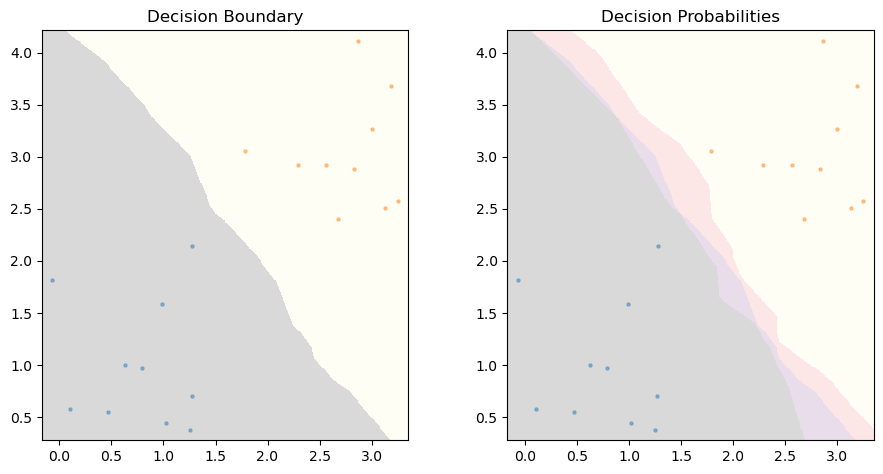

In [14]:
# let's plot how the decision space look like 
# to plot the decision space, we need to call plot_decision method with the following input
# input: 1- data features (accepts 2 features matrix only)
#        2- data labels ( 1d array )
#        3- a model ( such as knn in this case)

# call plot_decision
plot_decisison (   ,   ,    ) # complete the code here

3
5
7
3 kNN models have been created and trained..
The best model is (1)
The performance of Model 1 is 0.95:


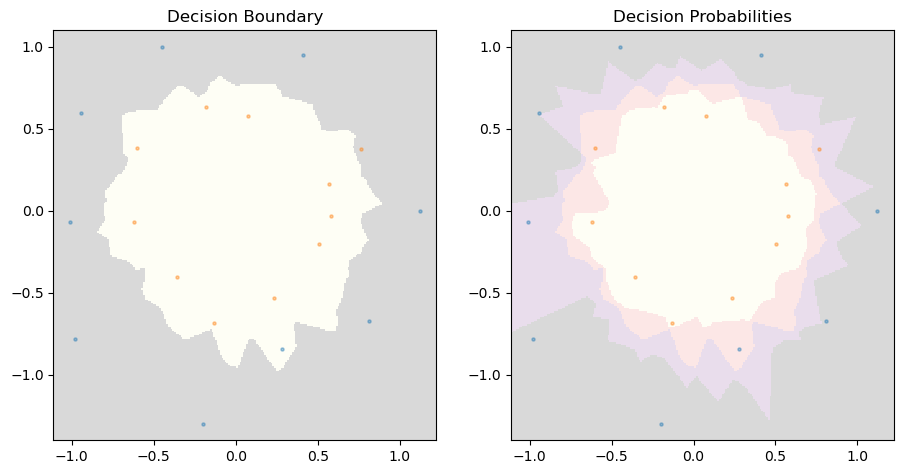

In [15]:
# let us repeat the above work using circul dataset Xctr, yctr.

# Let us use the circule data and call the method KNNModels to generate 3 models
knns = # complete the code here

# Evaluate using validation
accuracies = []

# loop here for each model 
for  # complete the code here





# get index of best knns    
bestmodel = accuracies.index(max(accuracies))+1

# start index is 1 
print ('The best model is (%d)'% (bestmodel))

# performance of the best model is 
print('The performance of Model %d is %.2f:'% (bestmodel, max(accuracies)))

# let's plot how the decision space look like 
plot_decisison (  ,  ,   ) # complete the code here


*********************

3
5
7
3 kNN models have been created and trained..
The best model is (1)
The performance of Model 1 is 1.00:


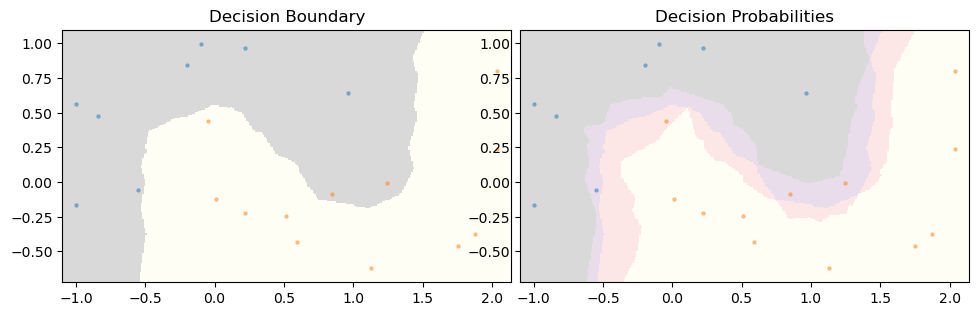

In [16]:
# Study the behavior of the classifier on moons dataset.

# Let us use the moons data and call the method KNNModels to generate 3 models
knns =  # complete the code here

# Evaluate using validation
accuracies = []
for  # complete the code here



    
    
    
    
# get index of best knns    
bestmodel = accuracies.index(max(accuracies))+1

# start index is 1 
print ('The best model is (%d)'% (bestmodel))

# performance of the best model is 
print('The performance of Model %d is %.2f:'% (bestmodel, max(accuracies)))

# let's plot how the decision space look like 
plot_decisison (  ,  ,   ) # complete the code here


We can observe that as K is small, the model is able to produce complex decision boundaries!

[Return to Table of Contents](#TableOfContents)

<a id=PQuestion3></a>

## Exercise 2 [Multi classes classification]

kNN classifiers can deal with multi-class problems. Use fruits dataset loaded in previous cells above. We want to classify the fruit dataset using kNN classifier. 

We can follow the above scenario by dividing the **training data** into train and validation sets to build the models. Then, we report performance using **testing dataset **


[Go Top](#TableOfContents)

In [17]:
# F
# Divide the data into training and validation sets using train_test_split
Xtr, Xtv, ytr, Vtv =  train_test_split(fruit_X_train,
                                       fruit_y_train,
                                       test_size=0.2, 
                                       random_state=20)


In [18]:
# create the 5 models using our previous function KNNModels
# note: training part of the data has to be used
knns =  # complete the code here

3
5
7
9
11
13
5 kNN models have been created and trained..


In [19]:
# Evaluate using validation
accuracies = []
for  # complete the code here




    
# show results 
# get index of best knns    
bestmodel = accuracies.index(max(accuracies))+1

# start index is 1 
print ('The best model is (%d)'% (bestmodel))

# performance of the best model is 
print('The performance of Model %d is %.2f:'% (bestmodel, max(accuracies)))

# what is the parameters of the best model
print('Model parameters:',knns[bestmodel].get_params() )

The best model is (1)
The performance of Model 1 is 0.60:
Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


 **Note**
 
 From the above information, we can select the model parameters and buil another model on the full training data, then make our final evaluation

In [20]:
# The above scenario allows us to select a  model, let set the best model's paramters and build a model using the full training
# data

# Configure the model with best paramters you found
knn = KNeighborsClassifier(   ) # complete the code here

# train the model 
knn. # complete the code here

# let us evaluate and report the results (accuracy) we can use knn.score
print('Results:',     ) # complete the code here

Results: 0.5


**Observation**

what is your observations? double click this text and **edit your answer**

[Return to Table of Contents](#TableOfContents)

<a id=PQuestion5></a>

# Exercise 3: Base performance

## Null accuracy

In this exercise, we will build a dummy ML model with most frequent strategy to compute the null accuracy as a base for better modeling and results. To do that, let us consider the furit dataset and build the model to findout what is our base accuracy for this dataset

**Doc:** https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [21]:
# load the dummy classifier
from sklearn.dummy import DummyClassifier

## Fruit dataset

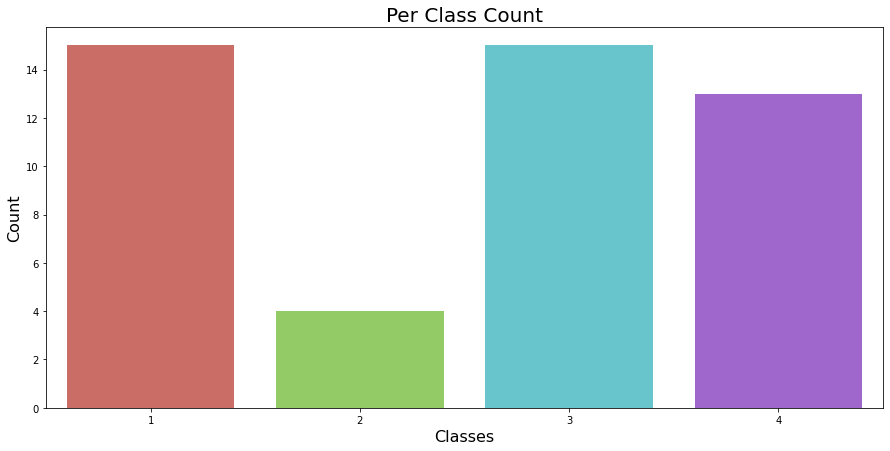

In [22]:
# let us use the fruit dataset (train)
# X_train and y_train are both extracted from fruit dataset previously

# let us check how balanced are the data
plt.figure(figsize=(15, 7))
axs= sns.countplot(x='classes',  data=pd.DataFrame({'classes': fruit_y_train}), palette='hls')
axs.set_xlabel('Classes',size=16)
axs.set_ylabel('Count',size=16)
axs.set_title('Per Class Count', size = 20)
plt.show()

**Observation**

what is your observations? double click this text and **edit your answer**

In [23]:

# let us initiate the model and set the strategy parameter to most_frequent
dummy_clf = DummyClassifier(strategy = "most_frequent")

# fit dummy_clf 
dummy_clf.  # complete the code here

# compuete the score the dummy classifier
scr = dummy_clf.  # complete the code here

# plot the null accuracy
print('Baseline score:(%0.2f%%)'%(scr*100) )

Baseline score:(31.91%)


## Facies dataset

Facies classification dataset. It consists of seven features five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE. Also, it has two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS). Moreover, it contains facies labels at half foot depth intervals. There are 9 facies labels as described below:  
1.	Nonmarine sandstone
2.	Nonmarine coarse siltstone
3.	Nonmarine fine siltstone
4.	Marine siltstone and shale
5.	Mudstone (limestone)
6.	Wackestone (limestone)
7.	Dolomite
8.	Packstone-grainstone (limestone)
9.	Phylloid-algal bafflestone (limestone)


[hint for data preparation: 1) you can remove Well Name, 2) find and fix missing values, 3) put the data into X (data features) and y(Facies Classes).

In [24]:
# read the csv file facies_vectors.csv 

faciesdataraw = # complete the code here

# check the stats table 
faciesdataraw.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


**Observations:**
1. PE has less count (less samples)
2. Features are multi-scale as indicated from the table

In [25]:
# we can check quicklly if we have categorical data or information that we need to remove ( preprocess )
print('let us look at the data types of each column in the data:\n',faciesdataraw.dtypes)

let us look at the data types of each column in the data:
 Facies         int64
Formation     object
Well Name     object
Depth        float64
GR           float64
ILD_log10    float64
DeltaPHI     float64
PHIND        float64
PE           float64
NM_M           int64
RELPOS       float64
dtype: object


**There are some non-numerical data in the dataset. The formation, and well name. These two can  be removed**

In [26]:
# Remove the two object columns Formation and Well Name from the loaded dataset
faciesdataraw = # complete the code here to drop the two columns 

In [27]:
# Find out which columns has missing data

try:
    # new versions of sklearn doesn't have isna
    print(faciesdataraw.isna().sum())
except:
    print(faciesdataraw.isnull().sum())
    

Facies         0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64


In [28]:
# Let us remove the affected rows only. (Hint axis=0)

faciesdataraw = faciesdataraw. # complete the code here

# check the stats table again
faciesdataraw.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [29]:
# quick look at null values
print(faciesdataraw.isnull().sum())

Facies       0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64


In [30]:
# extract labels and Data from the dataframe
# labels are the column Facies
Facilabels =  # complete the code here

# data are the all columns except Facies ( you may drop this column from the dataframe)
Facidata   = # complete the code here

# Let us keep track feature names for visualization
featnames  = faciesdataraw.columns

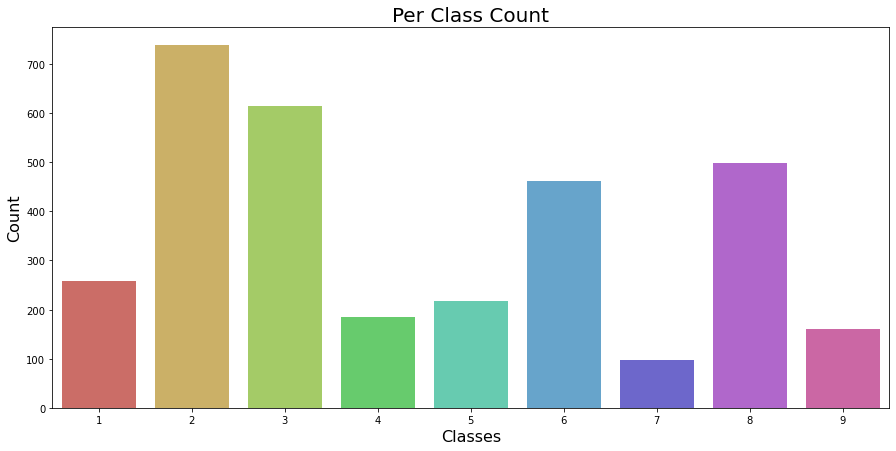

In [31]:
# let us show barchart of the data per feature
# seabron has countplot to serve this requirment (check the example below)
plt.figure(figsize=(15,7))

# countplot
axs= sns.countplot(x='classes',  data=pd.DataFrame({'classes': Facilabels}), palette='hls')

# plot labels 
axs.set_xlabel('Classes',size=16)
axs.set_ylabel('Count',size=16)
axs.set_title('Per Class Count', size = 20)
plt.show()

In [ ]:
# Null accuracy can be competed using a code as:
acc =[]
# for each label
for i in np.unique(Facilabels): 
    # compute the ratio lbl_count/(all lbls count)
    acc.append(float(len(Facidata[Facilabels == i, 0] ) / Facidata.shape[0]))

# Now the null accuracy is the max ratio among all computed above
print('Second dataset null-accuracy:{0:0.2f}%'.format(np.max(acc)*100))

**Dummy classifier** is useful to save time and compute the null accuracy

In [ ]:
# Build a dummy classifier to compute the base score

# instantiate the dummy clssifier with strategy
dummy_clf = # complete the code here


# fit the model
dummy_clf.fit(Facidata, Facilabels)


# compute the score of the model using the same data 
scr = # complete the code here

print('Second dataset null-accuracy:(%0.2f%%)'%scr )

**Observations:**

1. Our models should be better than 34% accuracy ( Fruit dataset )
2. Our model should be better than 23% accuracy ( Facies dataset )

********************

# Exercise 4: Model selection




[TOP](#TableOfContents)

### Let us find out kNN perfromance


In [34]:
# divide the data into training and testing
from sklearn.model_selection import train_test_split
# split the data into train and test
Xf_tr, Xf_ts, yf_tr, yf_ts = train_test_split(Facidata,
                                                    Facilabels,
                                                    test_size=0.2,
                                                    random_state=20)


# use the training data and split again to train and validation
Xf_trb, Xf_tsb, yf_trb, yf_tsb = train_test_split(Xf_tr,
                                                    yf_tr,
                                                    test_size=0.2,
                                                    random_state=20)

In [35]:
# Let us use our function to create several Knn models
# build  5 knn models using the training data trb
knns = kNNModels (5, Xf_trb, yf_trb)


# Run the code below
accuracies = []
for mdl in knns:
    ypred = mdl.predict(Xf_tsb)
    acc= accuracy_score(yf_tsb, ypred)
    accuracies.append(acc)
    
    
# Show results and best model 
bestmodel = accuracies.index(max(accuracies)) + 1
print('The best model is (%d)'% (bestmodel  ))
print('The performance of Model %d is %.2f:'% (bestmodel, max(accuracies)))
print('Model parameters:', knns[bestmodel].get_params() )

3
5
7
9
11
13
5 kNN models have been created and trained..
The best model is (1)
The performance of Model 1 is 0.69:
Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [ ]:
# Now as we found the best model configuration above 
# we need to rebuild the model with the whole training data tr

# write your code here to build, train, and compute the accuracy of your model



# let us evaluate and report the results
print('Results: %0.2f accuracy'%    ) # complete this line to shoud the accuracy

**Observations**

This is better than the baseline, if you are not satisfy with this accuracy think of imporvment by finetune the model's parameters

[TOP](#TableOfContents)

# Exercise 5 : Resampling data

In this exercise, we want to balance the trianing data for the sake of developing a better model for facies classficiation. It can be noticed that classes 1, 4, 5 7  and 9 have few samples compared to classes 2, 3, 6 and 8. Therefore, our target is to increase samples of these classes by 20%

**Example**, in case having a binary dataset with class distribution 357 in class1 and 212 in class2, we can balance class2  to 50% instead of the current representation 37.3% by adding this amount of samples

**sapmles = (0.5(total_samples) - class_i_samples) / (1 - 0.5)**


In [38]:
# let us rebuild DataFrame with format (labels - data )

# Combine the numpy arrays yf_tr and Xf_trb in Xf (use append)
Xf = # complete the code here

# Convert Xf into DataFrame, use feature names save before in featnames
trainFacies = pd.DataFrame(    ) # complete the code here

In [39]:
trainFacies.head()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3.0,2722.0,40.070,0.595,0.300,8.950,4.900,1.0,1.000
1,8.0,2971.5,13.617,0.596,1.367,11.133,4.441,2.0,0.500
2,2.0,2861.5,67.140,0.727,3.800,8.490,3.300,1.0,0.765
3,3.0,2931.5,67.670,0.430,-9.900,31.450,2.700,1.0,0.300
4,2.0,2732.5,73.930,0.334,5.900,14.050,3.000,1.0,0.400


In [ ]:
# For each class, 
# 1- we want to get how many samples
# 2- compute the number of the new samples that we need to add
# 3- resample this number and added it to the class-samples


# Let us loop for each class that we traget
# let us make simple, what are the ables of target classes to be resampled

tgclasses = [  ] # complete this line by adding the labels of the target classes

# just compute the total number of samples
totalsamples = len(yf_trb)

# let us make a copy of the Pandas original dataframe
trainFacies_upsampled = trainFacies.copy()

# This point starts the three point algorithm mentioned above 
for i in tgclasses:
    
    # get how many samples in class i
    currsamples = # get number of samples currently per class i 
    
    # Compute how many samples need to be resampled for class i ( our target is 15% increase)
    num_sapmles  =  # complete the code here using the equation (Exercise 5 description) 
    
    # show how many samples we need to increase the samples in class i by 15%
    print('%d smaples neede for class(%d)'%(num_sapmles, i) )
    
    # step 3: resample:
    #1. Extract class i samples and save it in to_resample variable  (hint pd.loc to slice pandas)
    to_resample = # complete the code here
                        
    #2. sample with replacement from to_resample varaible (pandas provides a method called pd.sample(..)   )
    new_samples = to_resample.sample(  ,  ) # complete the code here ( 2 params )
                        
        
    #3. Concatonate back the new sampled data to the dataset (hint pd.concat(..) )
    # base data: trainFacies_upsampled 
    # new data:  new_samples
    trainFacies_upsampled = # complete the code here


In [ ]:
# visualize the bar chart of the  trainFacies_upsampled and compare with previous bar char of the original data

# Write your code after this  (hint sns.countplot)





*************

In [ ]:
# let us perform the modeling again

# Let us use our function to create several Knn models
yf_trs = trainFacies_upsampled['Facies'].values
Xf_trs =trainFacies_upsampled.drop(['Facies'], axis=1).values
knns = kNNModels (5, Xf_trb, yf_trb)


# Evaluate using validation
accuracies = []
for mdl in knns:
    ypred = mdl.predict(Xf_ts)
    acc= accuracy_score(yf_ts, ypred)
    accuracies.append(acc)
    
# Show results 
bestmodel = accuracies.index(max(accuracies))+1
print ('The best model is (%d)'% (bestmodel  ))
print('The performance of Model %d is %.2f:'% (bestmodel, max(accuracies)))
print('Model parameters:',knns[bestmodel].get_params() )

In [ ]:
# Train a KNN model on full trianing set and evaluate using testing dataset 

knn = KNeighborsClassifier(n_neighbors=5) # rest are defaults
knn.fit(Xf_trs, yf_trs)
ypred = knn.predict(Xf_ts)

# let us evaluate and report the results
print('Results: %0.2f'% knn.score(Xf_ts, yf_ts))

**Observatinos**

As the model is KNN which is a memory based model, the resampling doesn't affect its performance. However, it may help other machine learning algorithms to boost their performance. 

<a id=PQuestion6></a>

# Exercise 6: Confusion Matrix

To understand the ML model mistakes, we need to compute the confusion matrix of the model performance. In this, exercise, refer to your models results in **Exercise 5** and use the predicted results to plot the confusion matrix. Study the confusion matrix and figure out what were the performance issues. 

[Return to Table of Contents](#TableOfContents)

In [ ]:
# load the confusion_matrix module form metrics
from  # complete the code here


# compute the confusion matrix 
# input: true labels, and predicted labels

mtConf = # complete the code here


# print the confusion matrix
print(mtConf)

### In multi-class, it is better to plot the confusion matrix rather than showing the matrix:
    

In [ ]:
# sklearn provides a confusion matrix display module as bleow
from sklearn.metrics import ConfusionMatrixDisplay

# make sure you have computed the confusion matrix as we did in the previous cell
# then pass the confusion matrix to the display to visualize

# 1- make the display
disp = ConfusionMatrixDisplay(    ,     ) # complete the code here ( 2 params)

# 2- call the plot of the disp with any color map you prefer
disp.plot(cmap='plasma') # check matplot color maps online


# To control the size of the plot
plt.tight_layout(rect=(0,0,2,2))
# show
plt.show()

***************

 **Errors:**
* 9 samples of class-1 could be similar to class-2 samples
* 15 samples of class-2 could be similar to class-1, and 10 samples of class-2 are similar to class-3
* and so on

**suggested scenarios:**

1. First, we may need to revisit data if we don't know a reason behind this overlapping
2. The sample overlapping may be due to human error while labeling samples
3. Could be no error and these classes have high inter-similarity and we need to keep the situation as is, or 
4. One solution from an expert could be to merge the overlapping classes to have simpler problem as stage 1,  and then explore solutions for those merged classes separately. 

From the confusion matrix, we can still compute:
* accuracy

In [48]:
# Use the pervious computed confusion matrix mtConf

# Sum over the diagonal of the matrix over the sum of all cells
acc =  # complete the code here

print('Accuracy:%0.2f%% '% (acc*100))

Accuracy:64.30% 


# Exercise 7 (Understand the model performance)

Now it is time to study the model performance. Suppose we build a ML model using some dataset, we want to know how precise this model is (in identifying positive class samples), and how about correctly identify positive samples from not reject them as negative class samples (recalling). 

**Note:** The above scenario is for binary classification, we usually compute the average of the precision and recall for multi-class classfication problems

Finally, as there is a tradeoff between recall and precision in most cases, we could endup trying to summarize these two metrics into single value indicator similar to accuracy called F1-score (or fmeasure)

[Return to Table of Contents](#TableOfContents)

In [49]:
# Task 1:Precision of the testing results
# Compute precision  (use macro average )
precision =  # complete the code here
print('Experiment Precision = %0.2f '%precision)

Experiment Precision = 0.64 


In [50]:
# Task 2:Recall of the testing results
# Compute Recall (use macro average )
recall =  # complete the code here
print('Experiment Recall =%0.2f '% recall)


Experiment Recall =0.67 


*****

**Note:**
* As the gap between precision and recall is not large and yet both are good values, it is a good sign of a robust model.
* Although the results above show the model doesn't incline towards one class against the other heavily, with the results above we may need to improve, 

In [51]:
# Task 3:fmeasure of the testing results
# Compute F1-score  (use macro average )
f1score =  # complete the code here  
print('Experiment F1score = =%0.2f '% f1score)

Experiment F1score = =0.64 


**Note:**

There are different averaging we can compute, **micro, macro and weighted**. In case of a imbalanced data weighted can be used to report the results!

In [ ]:
# We can easily display all possible performance metrics printting the classification report
print(  ) # complete the code (hint classification_report(..) )

****

**Note:** Classificaiton report can accept labels parameter. The labels paramter can be a list of numbers or text names, you can try it below

In [53]:
# Show a subset evaluation of all classes, just drop class label 4 from the list
labels = [1,2,3,5, 6, 7, 8, 9]
print( ) # complete the code (hint classification_report(..) )

              precision    recall  f1-score   support

           1       0.66      0.78      0.71        64
           2       0.71      0.70      0.70       148
           3       0.84      0.65      0.73       109
           5       0.43      0.62      0.51        47
           6       0.65      0.54      0.59       100
           7       0.61      0.74      0.67        19
           8       0.70      0.46      0.56        87
           9       0.77      0.87      0.82        31

   micro avg       0.68      0.64      0.66       605
   macro avg       0.67      0.67      0.66       605
weighted avg       0.69      0.64      0.66       605



***********

# Exercise 8 (Cross validation)

As the data is imbalanced, we may be lucky and get the best possible testing data chunk out of the random splitting. To investigate this issue in our results, a K-Fold can be used to split the data into different chunks. Every chunk is divided into train and test data.  Then, for each chunk, a model can be trained and tested. The score of each run is kept for final calculation of the performance. Reuse the data in Question 1.5 for 5-fold cross validation and compute the accuracy metrics.

Use **trainFacies** dataframe created in a previous exercise

Set the k = 3 for knn and build the model


 



[Return to Table of Contents](#TableOfContents)

In [54]:
# Let us show you the data structure again with head(5)
trainFacies. # complete the code here

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3.0,2722.0,40.070,0.595,0.300,8.950,4.900,1.0,1.000
1,8.0,2971.5,13.617,0.596,1.367,11.133,4.441,2.0,0.500
2,2.0,2861.5,67.140,0.727,3.800,8.490,3.300,1.0,0.765
3,3.0,2931.5,67.670,0.430,-9.900,31.450,2.700,1.0,0.300
4,2.0,2732.5,73.930,0.334,5.900,14.050,3.000,1.0,0.400


- [x] **Facies:** is the target variable /t
- [ ] **Other :** are features 

In [ ]:
# prepare scores list
score =[]

# We need to configure KFold
# let us make 5 splits with no data shuffling
kfold = KFold(n_splits =5, shuffle = False)


# Now kfold can split the data into train and test, we need to set a loop for that
# so that each time new train and test sets are generated for 5 times as we configure
# before
for train, test in kfold.split(trainFacies):
    
    # configure the knn classifier with k = 3
    knn = KNeighborsClassifier(n_neighbors=3)
    
    # let us feed the training stage with training data (slicing the original)
    # Now we need to use the train indices to do that 
    # remember first column in the dataset is the label
    knn.fit(trainFacies.iloc[train, 1:], trainFacies.iloc[train, 0] ) 
    
    # Similarily, we need to slice the dataset to extract the test set 
    # use the test indices test to slice 
    score.append(knn.score(trainFacies.iloc[test, 1:], trainFacies.iloc[test,0]))
    
# as the loop ends, score list will have 5 scores per each data split
# let us check them out by visualizing them
plt.plot(np.linspace(0,max(score), len(score)), score, 'o--' )
plt.title('CV score:%2f without shuffling!' % np.mean(score))
plt.show()

**Observation:** each division shows different results, if we lucky with train-test scenario, we can get up to 69% accuracy! 

**The above results are using k=3 only** We want to improve and find maybe better k

<a id=PQuestion9></a>

# Exerice 9 (validation for model selection)

We assume that our target search space is to determine which K value is the best for the Facies dataset. Therefore, we decided to reuse the above code from Exercise 8 and add to it a simple outter loop that picks new K value each time and perform cross validation. Finally, we can decide which model is the best. Let us set Ks = [3, 5, 7, 9]. plot the scores as shown above per each iteration 

[Return to Table of Contents](#TableOfContents)

In [ ]:


# Kfold case 1 ( no shuffle )
kfold = KFold(n_splits =5, shuffle = False)

# let us make list of possible k values ( 4 models )
ks =  # complete the code here

# To select a model, need to build several models using cross-validation and select the optimal one based on an objective 
# let us set our objective as the highest accuracy!
# we need to have two loops. First loop for loop different models, while second loop is to perform cross-validation 


i = 1
# loop 1: using different ks (different models)
for k in ks:
    
    # here we repeat the previous cell code exactly, and make a minor change at the line where we configure the model
    score =[]
    # main loop to perform cross validation
    for train, test in kfold.split(trainFacies):
        
        # confgireu the model
        knn =  # complete the code here
        
        
        
        # fit the knn using trainFacies dataframe - index it using train from the loop
        knn.fit(trainFacies.iloc[train, 1:],trainFacies.iloc[train, 0] ) 
        
        # compute the score using test indices and appended the score to our scores list
        score.append(knn.score(trainFacies.iloc[test, 1:],trainFacies.iloc[test,0]))
        
    plt.subplot(2,2,i)
    plt.plot(np.linspace(0,max(score), len(score)), score, 'o--' )
    plt.title('K = %d, CV score:%2f' % (k, np.mean(score) )) 
    i+=1
    
plt.tight_layout(rect=(0,0,1.5,1.5))
plt.show()

<a id=PQuestion10></a>

# Exericse 10: (Grid Search)

Grid search makes the coding in pervious exercise much simpler. We don't need to code loops and check each line, we only need to call this method GridSearchCV with certain paramters to return with the best estimator (model).
Let us try Grid search to determine the best model among k = [3, 5, 7, 9]



[Return to Table of Contents](#TableOfContents)

In [ ]:
# list of possible K values
ks = [ 3, 5, 7, 9]


# configure Gridsearch param - 
# A dictionary is expected for paramters in GridSearch
# The dictionary must have a key matches the model parameter and a value of your choice

param = {      } # complete the code here 

# instantiate the gridsearch with this format (estimator, param, cv, scoring )
model = GridSearchCV(KNeighborsClassifier(), param_grid = param, cv = 5, scoring ='accuracy')


# Train the gridsearch model using Facies dataset
model.fit( trainFacies.iloc[:, 1:], trainFacies.iloc[:,0])

# Get the best model (paramters)
# Gridsearch provides an attribute called best_estimaor_ where it saves information about the best model found

print(     ) # complete the code here

**Note:**
1. The best value for k is an issue of this algorithm. You should know that small value of K $\approx 0$ means senstive model (overfitting) and a larger value of k means dummy model (most frequent strategy). 
1. A rule of thumb here is to choose **$k=\sqrt{n}$** where n is the number of samples. better choice is to run the kNN with different ks on the training data. Then, decide which K value to choose from as we did in the pervious exercise. 

[Return to Table of Contents](#TableOfContents)

<a id='P2Question1'></a>

# Exerice 11 

In this exercise, we want to predict a fruite class using Logistic regression method. As described before, the fruites dataset has four features and one target variable. The features include  


[Return to Table of Contents](#TableOfContents)

In [ ]:
# load the logisticregression from the library
from sklearn.linear_model import LogisticRegression

# instantiate a model 
logModel1 =  # complete the code here

# train the model (using fruit training data -  fruit_X_train and  fruit_y_train)
# complete the code here 

**Obervation:**
The model training algorithm has a complaint as the warning above. to get rid of the warning above by increasing the iterations to 10000, or scale as we do below

In [ ]:
# Pipeline model
# this model combines preprocessing with an estimator. It is great way to preprocess the data before building a model
# another benefit, scales parameters ( max, min, std etc) are computed during training and the pipeline keeps track 
# of them. So, at the testing time, we need to provide the raw data and pipeline will make sure to scale them before
# compute the predictions

# As we have the warning above, it is good to build a pipeline instead

# instantiate a model format (Transformer Class, Estimator Class) 
# let us standardscaler and logistic regression 
modelLg = make_pipeline(   ,    ) # complete the code here

# train the model as normal
modelLg.fit(fruit_X_train, fruit_y_train)

In [ ]:
# Task 4: Classify the test dataset and compute the performance accuracy score.
# Now the pipeline modelLg knows the scalling parameters and has ready trained estimator (model)
# we need to pass the testing data to it only.

# predict labels of new data
y_pred = modelLg.predict(fruit_X_test)  

# To validate and computethe accuracy on test set       
print(classification_report(fruit_y_test, y_pred))

**The results above is way better than KNN in Exercise 2**

# Exercise 12 ( Hard dataset for Logistic Regression)

Any non-separable dataset is tough for Logistic Regression to make good performance. Therefore, we need to preporcess the data to enable Logistic Regression finds a good decision bounary. For example, circular dataset is one hard dataset for logistic regression but we can help the model to solve it

In [ ]:
# Study the behavior of the logistic Regression on different datasets as circles, moons. How successful was it?

# Circule dataset
# instantiate the logistic regression 
logModelcr = # complete the code here

# train the model using Xctr yctr
# complete your code here

# predict labels of testing data Xcts
y_pred = # complete your code here

# To validate and computethe accuracy on test set       
print('Accuracy:', accuracy_score(ycts,y_pred))

# let's plot how the decision space look like 
plot_decisionline (logModelcr, Xcts, ycts , SVM_Model=False )

plt.show()

**Was the logistic regression successful in separating the two data classes?**


### Transform the data


To build a better model, we need a composite model that perform transformation to the data and then build a classifier. For circular data, we need to add a higher degree feature to separate the inner circle from the outer one. A Guassian transformation could be suitable in this circule dataset as well as polynomials. Let us check the following code cell 

### A Guassian transformation
a [function defined in the beginning](#transform_fea) of this notebook can be used to transform the data and has the form of 
$r =  e^{-X^2}$

In [ ]:
# a custom developed transformer GaussianTransformation


# Build a pipeline by including a transformer and logistic regression model
modelcir = make_pipeline(GaussianTransformation(), LogisticRegression())


# Train the model modelcir with the traiing data
modelcir.fit(Xctr, yctr)


# Classify the testing data
y_pred = modelcir.predict(Xcts)

# compute the accuracy of the predictions
print ('Testing Accurracy %0.1d%%'% (accuracy_score(ycts, y_pred) *100) )

**What do you think about the results?**

*********

In [ ]:
# visualize the new transformed data to understand what has happened:

# instantiate the Gaussian transformer
gt = # complete the code here

# Transform the Xctr dataset (hint use transform method )
newXctr = # complete the code here 

# plot 3D  ( X1 and X2, color, Z)
plot_3D(newXctr[:,:-1] , yctr, newXctr[:,-1])
plt.tight_layout(rect=(0,0,1.5, 1.5))
plt.title('Two groups can be separated in 3D', fontsize=18)
plt.show()

**Conclusion:**

1. Logistic regression classifier was able to find a perfect model using Blob dataset with clear separation. 
2. It hard and even harder to it to classify the moon and circule datasets. With circules the performance drops to around 50% which means a decision boundary cannot be found without model mistakes. 
3. We still can solve such hard problems with data transformation

[Return to Table of Contents](#TableOfContents)

******

# Exercise 13 (Support Vector Machines – Hard Margin)

In this exercise, let us explore hard margin SVM to classify clean data into two classes. The dataset is generated for you in the next cell. Use this 80% of data to build an SVM model with hard margin, and the rest used for testing.


In [64]:
# Separabale data to be classified and tested by SVM classifier
X_svm_hard, y_svm_hard = make_blobs(n_samples      = 300, 
                                      centers      = 2, #will define classes
                                      n_features   = 2, 
                                      cluster_std  = 1,
                                      random_state = 6)



[Return to Table of Contents](#TableOfContents)

In [65]:
# First thing first, to load the estimator from sklearn
# Load the classifier SVC from svm! Also, it has other versions of it 
from sklearn.svm import SVC 

********

In [ ]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_svm_hard, 
                                                    y_svm_hard, 
                                                    test_size  =0.2, 
                                                    shuffle    =True)

In [ ]:

# By default, svm uses rbf kernel, and controls the margin using paramter C
# Set C paramter to equal 1e20 (v. high value) for hard margin
# Set kernel  to 'linear'
svm_hard= SVC(    ,    ).fit(X_train, y_train)   # complete the code here


# The previous line will create a model using  training dataset
# compute the score (accuracy) on training dataset
scr = # complete the code here
print('Model score:',  scr   ) 


# Using a ploting function defined in this notebook to plot a decision space of your classifier svm_hard
# call plot decisionline with training data
    # write your code here ( 1 line) 

    
plt.tight_layout(rect=(0,0,1.5, 1.5))
plt.show()

**Study the plot above!** Based on the created data the margin is so tight and separates the two classes perfectly (training dataset). **Don't rush for softmargin, now**. Let's findout how good the results using the testing dataset

In [ ]:
# use the model above to predict testing labels
y_pred = # complete the code here

# check the classification report
print(classification_report(y_test, y_pred))

**Great results** 

To achieve such good results using SVM, we need to have a clean separable dataset from the beginning. But this is not how real-world datasets are. Usually, datasets suffer overlapping due to noise, labeling operator mistakes, or even overlapping naturally. As an example, circles or moons datasets are not separable in the first place.  Let us check the below exercise and study how SVM with Hard-margin will behave on such datasets 



**********

**Why we need to relax this condition?**

Now let's imagine by human error, a worker who responsible for labeling the data have committeed one mistake and label one sample incorrectly. How SVM with Hard margin will behave? Let us do that labeling mistake by changing one of the smaples labels to be in the other class and repeat the procedure above 

In [68]:

# Get an index of any example randomly 
ind = random.randint(0, len(X_train))


# let us convert that sample label from 0 to 1 or 1 to 0 
y_train [ind]  = 1 - y_train [ind] 

# Now our training set is contain one outlier or noisy data sample - let us check it affect on the model and results

**warning:** 

Based on the modified sample, the SVM with hard margin may take very long time to stop execution(converge). Therefore, you can set the **max_iter** paramter to a **1000** to stop the trianing after 1000 iteration  

In [ ]:
# Let us know build an svm_hard again with the traiing dataset as we did before

# write your code here to build a hard-margin SVM - max 2 lines to instantiate the SVM and train it
svm_hard = 



# compute the training accuracy 
scr =  # complete the code here
print('Model score:', scr)


# Using a ploting function defined in this notebook to plot a decision space of your classifier svm_hard
# call plot decisionline with training data
    # write your code here ( 1 line) 


plt.tight_layout(rect=(0,0,1.5, 1.5))
plt.show()

**Observations:**

double click this text to write your observation

In [ ]:
# use the model above to predict testing labels
y_pred = # complete the code here

# check the classification report
print(classification_report(y_test, y_pred))

**Conclusion:**

1. The above great dataset has affected severely with only one mistake
1. The SVM C hyperparamter is one very important to be tuned right for your probelm at hand

<a id='P2Question6'></a>

# Exercise 14 (Support Vector Machines – Soft Margin)


In the last exercise, we are not able to build a good model with a mistaken label due to the hard margin condition. Let's know relax this condition by control the C hyperparamter and reduce it is value. The smaller the value the softer the margin. 

[Return to Table of Contents](#TableOfContents)

In [ ]:
# By default, svm uses linear kernel, and controls the margin using paramter C
# To create an SVM with soft-margin we need to set small value for C, 
# based on the previous Exercise code-guides develop the current

# Write your code after this line

svm_soft= 





plt.tight_layout(rect=(0,0,1.5, 1.5))
plt.show()

In [ ]:
# use the model above to predict testing labels
y_pred = # complete the code here

# check the classification report
print(classification_report(y_test, y_pred))

**Obervation**

double click this text to write your observation

**How about non-separable dataset?** 

will soft margin enough to solve non-separable problms. let us try svm_soft on **circular dataset**

In [ ]:
# Using the circule dataset we created before Xctr, yctr and build svm
# instantiate and traing a soft margin svm
svm_soft2= # complete the code here 


# print the accuracy sore of the traiing
print('Model score:',svm_soft2.score(Xctr, yctr ))


# Using a ploting function defined in this notebook to plot a decision space of your classifier svm_hard
# call plot decisionline with training data
    # write your code here ( 1 line) 


plt.tight_layout(rect=(0,0,1.5, 1.5))
plt.show()

**Observation:**

Was the created model good or not to classify circle dataset?

Double click this text to answer this question

*****

# Exercise  15 (SVM and Kernels)

The kernel trick of SVM was designed to overcome the limitation encountered due to data non-separable problems. For instance, the XOR problem was presented to challenge discriminant classifiers such as SVM and Perceptron to solve. These linear classifiers weren't able to solve such problems until the idea of the kernel trick has emerged.  

The kernel trick is the transformation of data that took place within the machine learning algorithm itself. The kernel methodology is better than a pure transformation of data before modeling. If we perform a transformation before modeling, our data become huge and may be hard to be handled. However, in the kernel trick, the transformation is happening instantaneously during modeling. In addition, SVM performs that using support vectors only! 


The problem we created above is very diffcult to solve. One misslabeled sample in a middle of data-class makes a great problem. Let us try to slove this problem using RBF kernel. This kernel has a spread parameter **gamma**. The higher the value set for gamma the complex the model will be.  


In [ ]:
# Sklearn supports several SVC kernels 
# according to the documentation: four kenrels are supported ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
# the default kenrnel is the Radial Basis Function 'rbf'

# let start with our blob dataset that has a labeling mistake as indicated perviously.
# This dataset was solved by tuning the C parameter to small value (softmargin) with linear kernel.
# let us check the effect of the rbf kernel on the decision space using the same dataset
# Study the below code before run:

# let us set C to default = 1, and check the effect of  gamma param
# give gamma a range of values between 0.2 to 30 spaced with 7.5
gms = np.arange(0.2, 30, 7.5 )

# to control subplots
i = 1

# loop through gammas and build different SVM models
for gm in gms:
    
    # SVM with gamma = gm
    svm_RBFt= SVC( gamma=gm, kernel='rbf' ).fit(X_train, y_train)   
    
    # Visualize the decision boundary
    plt.subplot(2,2,i)
    
    plot_decisionline(svm_RBFt, X_train, y_train, SVM_Model=True)
    
    plt.title('RBF - gamma=' + str(gm) )
    
    # next subplot
    i +=1
    
plt.tight_layout(rect=(0,0,2,2))
plt.show()


**Observation:**

Study the plots above, what is the effect of gamma on the decision boundaries?

Double click this text to write your observation

**Circular dataset**

let us try to build a svm that can handle this dataset using RBF kenerl below

In [ ]:
#  RBF
# choose four values for gamma
gms = [ ,  ,  ,  ] # complete the code here

i = 1
for gm in gms:

    # build and train a model
    svm_soft2=  # complete the code here

    # accuracy
    score = # complete the code here

    
    # using the plot svm decision function supplied above to show the decision boundary
    plt.subplot(2,2,i)
    plot_decisionline(svm_soft2, Xcts, ycts, SVM_Model=True)
    
    # show the accuracy and gamma as title of each subplot
    plt.title('accuracy: '+ str(score) +  ' gamma=' + str(gm))
    
    # next subplot
    i+=1
    
    
    
plt.tight_layout(rect=(0,0,2,2))    
plt.show()

**Observations:**

Double click here to write your observations

*********

# Exercise 16 ( SVM - Facies dataset )

In **Exercise 5**, we balanced the facies data and finetune KNN to classify the faceis dataset into 9 classes. The best model's results is **65% accuracy**. Let us use the facies dataset in this exercise and build SVM model with RBF kernel. 

we want to start with small gamma and set C value to 2 as our baseline results for SVM. C = 2 is still soft-margin, however small gamma is not so flexible. 

Then, we want to make use **GridSearchCV** to find a robust and the best SVM model to deal with this dataset using four gammas and four Cs.  Let set the four values for gammas between 0.001 to 1 and the other four values for C be 1 to 100

In [77]:
# Base code 
# RBF different gammas
svm_rbf= SVC(kernel='rbf', gamma = 0.001, C=2).fit(Xf_trb, yf_trb)   

# let us compute the classification report 
y_pred = svm_rbf.predict(Xf_tsb)
report = classification_report(yf_tsb, y_pred)

# using the plot svm decision function supplied above to show the decision boundary
print (report)

              precision    recall  f1-score   support

           1       0.57      0.78      0.66        32
           2       0.64      0.68      0.66       121
           3       0.73      0.68      0.71       101
           4       0.53      0.69      0.60        29
           5       0.51      0.77      0.62        31
           6       0.59      0.49      0.54        67
           7       0.56      0.88      0.68        16
           8       0.78      0.49      0.60        99
           9       0.86      0.90      0.88        21

    accuracy                           0.65       517
   macro avg       0.64      0.71      0.66       517
weighted avg       0.67      0.65      0.65       517



In [ ]:
# Let us finetune the gamma and C paramters using GridSearch

# values to finetune svm
Cs     = [ , ,  , ] # complete the code here
gms = [ ,   ,  , ] # complete the code here

# dict parameters
param = {'C': Cs, 'gamma': gms, 'kernel': ['rbf']}

# instantiate the gridsearch method ( estimator, param, cv, scoring )
model = # complete the code here


# Cross validate the data
model.fit(Xf_trb,yf_trb)

# get the best model (paramters)
print(model.best_estimator_)

**********

In [ ]:
# Rebuild the SVM with the best params found above
# data:  Xf_trb, yf_trb
svm_rbf=  # complete the code here

# let us compute the classification report 
# data: Xf_tsb
y_pred =  # complete the code here

# compute the classification report
# True labels: yf_tsb
report = # complete the code here



# using the plot svm decision function supplied above to show the decision boundary
print (report)

****

**The results is way better than what KNN achieved so far!**

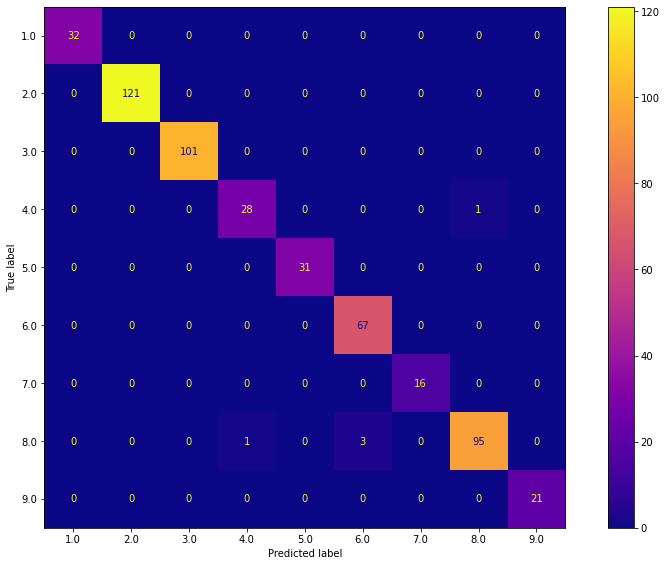

In [80]:
# Visualize the confusion matrix to related mistakes
# testing data used 
# confusion matrix
mtConf =  # complete the code here

# Display confusion matrix 
disp = # complete the code here


# display the matrix with plasma coloring
disp.plot(cmap='plasma')


plt.tight_layout(rect=(0,0,2,2))
plt.show()

*************

*************

# Additional  Exercises

<a id='P2QuestionOptional2'></a>

## Parctice and study (Cancer Dataset (2 Features))

Scikit learn shipped with some benchmark datasets such as iris, house-prices, and cancer data. In this exercise, we are going to explore Cancer dataset.  
 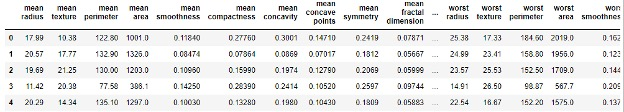

This dataset contains 30 different features. For the purpose of this exercise, pick two features **“mean radius, and mean perimeter”** and use them as a new dataset to perform the following tasks.    


**Other classifiers** 

Sklearn has several other classifiers that you might be interesting to study. For example another non-paramtric classifier is the **Decision Trees Classifier** and the ensemble family of classifiers such as Random Forest, and Boosting classifiers. These classifiers are very strong to model hard problems too. 

Linear Discriminant Analysis (LDA) is another classifier that brings together data reduction and separation at the same time. It has a workflow similar to PCA however, it maintains separation between classes. For more informaiton about the **Sklearn classifiers** let me invite your to check the [Sklearn cheatsheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)


[Return to Table of Contents](#TableOfContents)

In [81]:
# load the LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [82]:
# Load the dataset
from sklearn.datasets import load_breast_cancer
Cancer = load_breast_cancer()

In [83]:
# convert it to dataframe and check its properties
cancer_pd = pd.DataFrame(data=Cancer.data, columns=Cancer.feature_names)
labels = Cancer.target

# show the features
print('Number of features:', len(Cancer.feature_names)); print()
print('Labels:', set(labels)); print('\nFeature names:')
print(Cancer.feature_names[:,None])


Number of features: 30

Labels: {0, 1}

Feature names:
[['mean radius']
 ['mean texture']
 ['mean perimeter']
 ['mean area']
 ['mean smoothness']
 ['mean compactness']
 ['mean concavity']
 ['mean concave points']
 ['mean symmetry']
 ['mean fractal dimension']
 ['radius error']
 ['texture error']
 ['perimeter error']
 ['area error']
 ['smoothness error']
 ['compactness error']
 ['concavity error']
 ['concave points error']
 ['symmetry error']
 ['fractal dimension error']
 ['worst radius']
 ['worst texture']
 ['worst perimeter']
 ['worst area']
 ['worst smoothness']
 ['worst compactness']
 ['worst concavity']
 ['worst concave points']
 ['worst symmetry']
 ['worst fractal dimension']]


In [84]:
# check and clean the data
print(cancer_pd.describe())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

In [85]:
# let us check NA or non values 
cancer_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

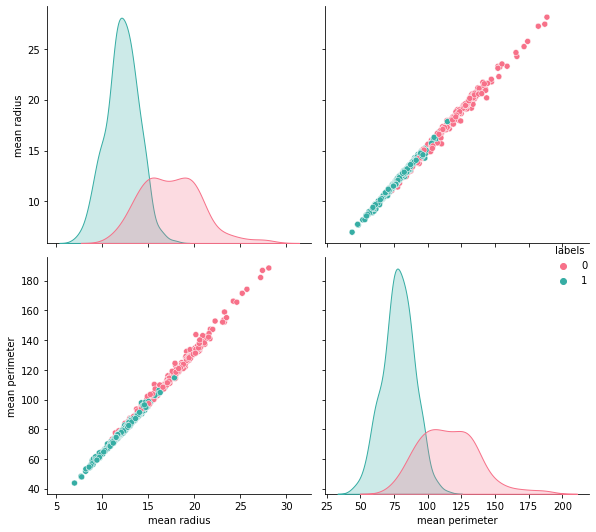

In [86]:
# slice two features from the dataset in sub_cancer_pd
sub_cancer_pd = cancer_pd[['mean radius', 'mean perimeter']]

# sub_cacner_pd['Labels'] = labels
sub_cancer_pd.insert(2, "labels", labels, True) 


ax = sns.pairplot(sub_cancer_pd, hue='labels', palette="husl",  vars=['mean radius', 'mean perimeter'] )
plt.tight_layout(rect=[0,0,1.5,1.5])
plt.show()


************

In [87]:
# Compute how many samples per class
sub_cancer_pd.groupby('labels').count()

,mean radius,mean perimeter
labels,,
0,212,212
1,357,357


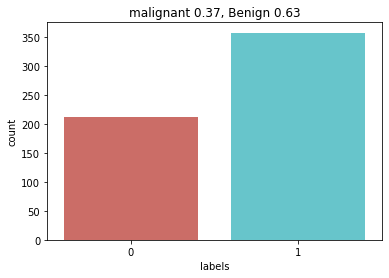

In [88]:
# Class distributions ( P1 and P2)
pp= sub_cancer_pd.groupby('labels').count()/ len(labels)
# pp['mean radius'].values
sns.countplot(x='labels', data = sub_cancer_pd, palette='hls')
mal_prob=np.round(pp['mean radius'].values[0],2 )
ben_prob= np.round(pp['mean radius'].values[1],2 )
plt.title("malignant {}, Benign {}".format(mal_prob, ben_prob ) )
plt.show()


In [89]:
# samples of the data
sub_cancer_pd.head()

,mean radius,mean perimeter,labels
0,17.99,122.80,0
1,20.57,132.90,0
2,19.69,130.00,0
3,11.42,77.58,0
4,20.29,135.10,0


In [90]:
# Base accuracy (Null)
dummy_clf = DummyClassifier(strategy="most_frequent")

# requires the fit - to target the most frequent data
dummy_clf.fit(sub_cancer_pd.iloc[:,:-1], sub_cancer_pd['labels'])

# show the base score - any model we built should be better than this
scr = dummy_clf.score(sub_cancer_pd.iloc[:,:-1], sub_cancer_pd['labels']) * 100
print('Baseline score:(%0.2f%%)'%scr )


Baseline score:(62.74%)


In [91]:
# divide the data into training and testing ( the data is imbalanced )
X_train, X_test, y_train, y_test = train_test_split(sub_cancer_pd.iloc[:,:-1], sub_cancer_pd['labels'], 
                                                    test_size=0.2, stratify = sub_cancer_pd['labels'], shuffle=True)

**Note:**

The above data is imbalanced. By the nature of the problem, cancerous (malignant) tumors are less than benign ones. Therefore, changing the nature of the dataset to be balanced may not be realistic. Consequently, we need to perform cross-validation and report the average performance instead.  

In [92]:
# # You can use the same data division used to generate the results below 
# # by uncommenting this lines
# import pickle
filename = 'Data/cancer_data_train_test.sav'
data = pickle.load(open(filename, 'rb'))
X_train, X_test, y_train, y_test = data


In [93]:
# Logistic regression model
# build a model and train it
logModel = LogisticRegression().fit(X_train, y_train)

# report the results using testing data
y_pred = logModel.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.86      0.88        42
           1       0.92      0.94      0.93        72

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



**Observation:** The results is good compared to baseline accuracy. We can improve this right! check the pairplot above of this data. we can observe an overlap between the classes. Therefore, we may fix it by transformation. Let us know build a pipeline classifier and try again

In [94]:
np.log(X_train)
X_train

,mean radius,mean perimeter
560,14.050,91.38
26,14.580,97.41
553,9.333,59.01
497,12.470,80.45
120,11.410,73.34
...,...,...
498,18.490,121.30
323,20.340,135.90
188,11.810,75.27
268,12.870,82.38


## Transformation
1. LOG TRANSFORMATION:
- It makes our data close to a normal distribution without fully abide by a normal distribution.
- Cannot be applied to negative values.
- Suitable to right-skewed data.
- Convert data from multiplicative scale to addictive Scale. 
1. RECIPROCAL TRANSFORMATION
- Not defined for zero.
- It has radical effect.
- It reverses order among values of the same sign, so large values become smaller and vice-versa.
1. SQUARE TRANSFORMATION
- It applies to left-skewed data.
- It is not a polynomial feature transformation!
1. SQUARE ROOT TRANSFORMATION:
- It is defined only for positive numbers.
- It can reduce the skewness of right-skewed data.

In [95]:
# custom transformation
from sklearn.base import TransformerMixin

# Square
class SquareTransformation(TransformerMixin):
    transformed_data = None
    def __init__(self):
        self.transformed_data = [] 
    
    def fit(self, X, y=None):
        return self
    
    # let us define our Guassian transformation becuase it fits circle datasets
    def transform(self, X, y=None):
        X_ = X.copy()
        X_  = X_**2
        self.transformed_data = X_
        return X_

# log transform
class LogTransformation(TransformerMixin):
    transformed_data = None
    def __init__(self):
        self.transformed_data = [] 
    
    def fit(self, X, y=None):
        return self
    
    # let us define our Guassian transformation becuase it fits circle datasets
    def transform(self, X, y=None):
        X_ = X.copy()
        X_  = np.log1p(X_)
        self.transformed_data = X_
        return X_

# Sqrt transform
class SQRTTransformation(TransformerMixin):
    transformed_data = None
    def __init__(self):
        self.transformed_data = [] 
    
    def fit(self, X, y=None):
        return self
    
    # let us define our Guassian transformation becuase it fits circle datasets
    def transform(self, X, y=None):
        X_ = X.copy()
        X_  = np.sqrt(X_)
        self.transformed_data = X_
        return X_

In [96]:
# let us use higher features using a transformer and report the classification above
from sklearn.preprocessing import PowerTransformer
# instantiate a model 
modelLg = make_pipeline(LogTransformation(), LogisticRegression( ))

# train the model
modelLg.fit(X_train.values, y_train)

# report the results using testing data
y_pred = modelLg.predict(X_test.values)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        42
           1       0.92      0.97      0.95        72

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



**Obervation:** A little progress in terms of accuracy 1%

## SVM: Cancer dataset

In [97]:
# SVM  model
# build a model and train it (rbf)
svmModel = SVC(gamma='auto', C=1).fit(X_train, y_train)

# report the results using testing data
y_pred = svmModel.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.83      0.90        42
           1       0.91      0.99      0.95        72

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



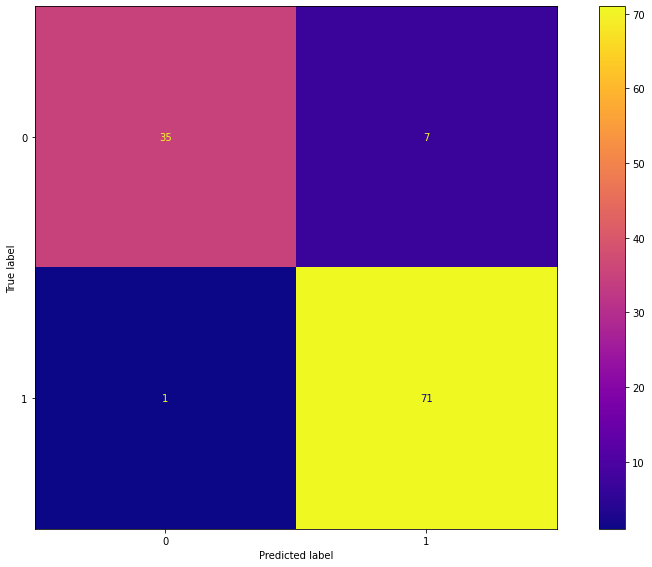

In [98]:
mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=svmModel.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()

In [99]:
# let check scale again
np.max(X_train)

mean radius        27.42
mean perimeter    186.90
dtype: float64

Better to rescale the data for SVM to work faster

In [100]:
# SVM  model ( It is recommended to scale data for SVM to reduce time )
svmModel = make_pipeline(MinMaxScaler(), SVC( ))

# train the model
svmModel.fit(X_train, y_train)

# report the results using testing data
y_pred = svmModel.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89        42
           1       0.91      0.97      0.94        72

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



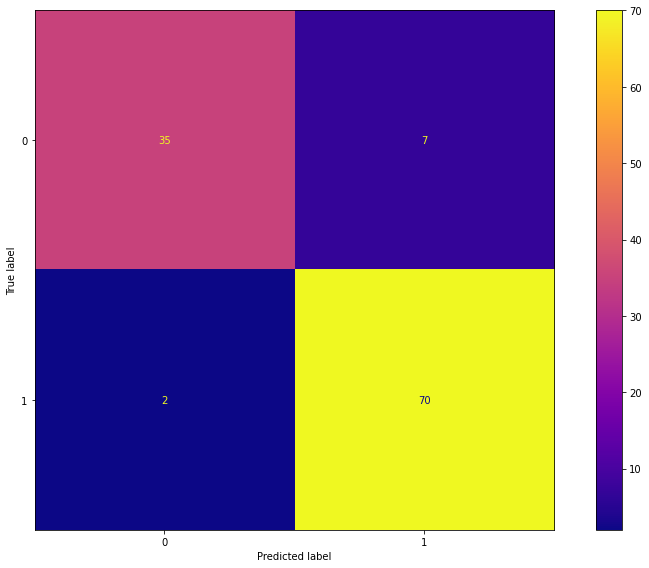

In [101]:
mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=svmModel.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()

In [102]:


Cs     = [0.1, 0.5, 1 ]
gms    = [10, 30, 'auto', 'scale' ]
deg    = [1, 2, 3 ]
# dict parameters
param = {'C': Cs, 'gamma': gms, 'degree': deg, 'kernel': ['poly']}

# instantiate the gridsearch method ( estimator, param, cv, scoring )
svmModel = GridSearchCV(SVC(), param_grid = param, cv=5, scoring='accuracy')

mnmx = StandardScaler().fit(X_train)

start = time.time()
svmModel.fit(mnmx.transform(X_train), y_train)
end = time.time()

#Execution time
total_time = end - start
print("Execution time: %0.2f minutes"%(total_time/60.0))


# report the results using testing data
y_pred = svmModel.predict(mnmx.transform(X_test))
print(classification_report(y_test, y_pred))

Execution time: 0.06 minutes
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.93      0.94      0.94        72

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



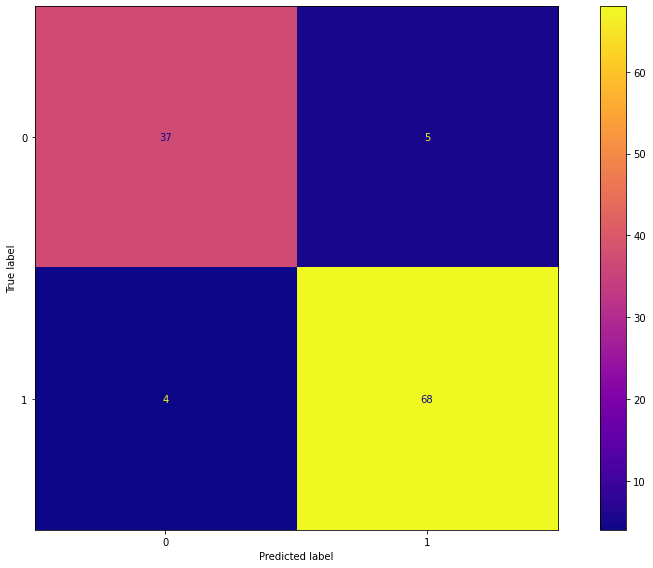

In [103]:
mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=svmModel.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()

In [104]:



# values to finetune svm
Cs     = [0.1, 0.5, 1 ]
gms    = [10, 30, 'auto', 'scale' ]

# dict parameters
param = {'C': Cs, 'gamma': gms, 'kernel': ['rbf']}

# instantiate the gridsearch method ( estimator, param, cv, scoring )
svmModel = GridSearchCV(SVC(), param_grid = param, cv=5, scoring='accuracy')

mnmx = MinMaxScaler().fit(X_train)

start = time.time() 
svmModel.fit(mnmx.transform(X_train), y_train)
end = time.time()

#Execution time
total_time = end - start
print("Execution time: %0.2f minutes"%(total_time/60.0))


# report the results using testing data
y_pred = svmModel.predict(mnmx.transform(X_test))
print(classification_report(y_test, y_pred))





Execution time: 0.00 minutes
              precision    recall  f1-score   support

           0       0.97      0.83      0.90        42
           1       0.91      0.99      0.95        72

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



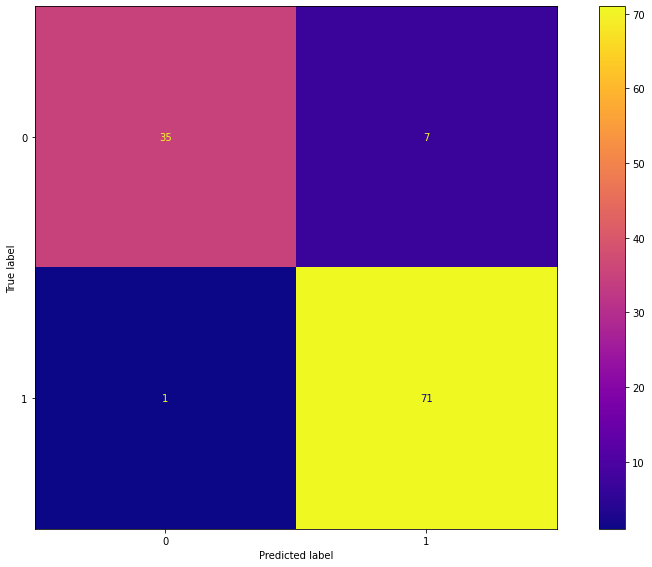

In [105]:
mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=svmModel.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()

In [106]:



# values to finetune svm
Cs     = [0.1, 0.5, 1 ]
gms    = [10, 30, 'auto', 'scale' ]

# dict parameters
param = {'C': Cs, 'gamma': gms, 'kernel': ['sigmoid']}

# instantiate the gridsearch method ( estimator, param, cv, scoring )
svmModel = GridSearchCV(SVC(), param_grid = param, cv=5, scoring='accuracy')

mnmx = StandardScaler().fit(X_train)
start = time.time()
svmModel.fit(mnmx.transform(X_train), y_train)
end = time.time()

#Execution time
total_time = end - start
print("Execution time: %0.2f minutes"%(total_time/60.0))


# report the results using testing data
y_pred = svmModel.predict(mnmx.transform(X_test))
print(classification_report(y_test, y_pred))

Execution time: 0.00 minutes
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        42
           1       0.93      0.88      0.90        72

    accuracy                           0.88       114
   macro avg       0.87      0.88      0.87       114
weighted avg       0.88      0.88      0.88       114



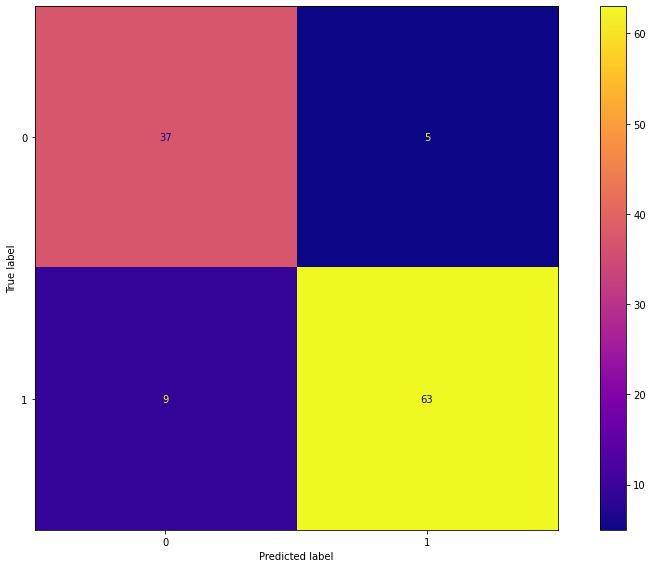

In [107]:
mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=svmModel.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()

In [108]:
# values to finetune svm
Cs     = [0.1, 0.5, 1 ]
gms    = ['auto', 'scale', 10, 30  ]
deg    = [1, 2,3] 

# dict parameters
param = {'C': Cs, 'gamma': gms, 'degree': deg,  'kernel': [ 'poly', 'rbf','sigmoid']}

# instantiate the gridsearch method ( estimator, param, cv, scoring )
svmModel = GridSearchCV(SVC(), param_grid = param, cv=5, scoring='accuracy')

mnmx = StandardScaler().fit(X_train)

svmModel.fit(mnmx.transform(X_train), y_train)

# report the results using testing data
y_pred = svmModel.predict(mnmx.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.93      0.94      0.94        72

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



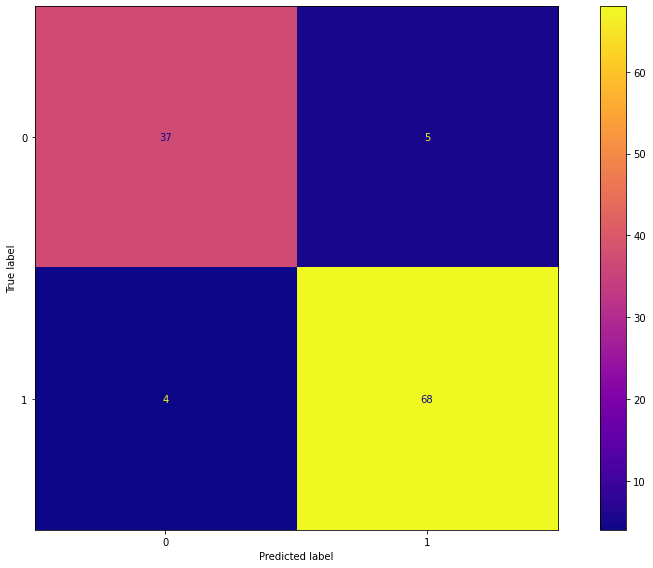

In [109]:
mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=svmModel.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()

In [110]:
# show configuration of the best
svmModel.best_estimator_

SVC(C=1, degree=1, gamma=30, kernel='poly')

## Linear Discriminant Analysis: Cancern dataset

In [111]:
# Task 3
# Using the LDA from scikit learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        42
           1       0.88      0.96      0.92        72

    accuracy                           0.89       114
   macro avg       0.90      0.87      0.88       114
weighted avg       0.90      0.89      0.89       114



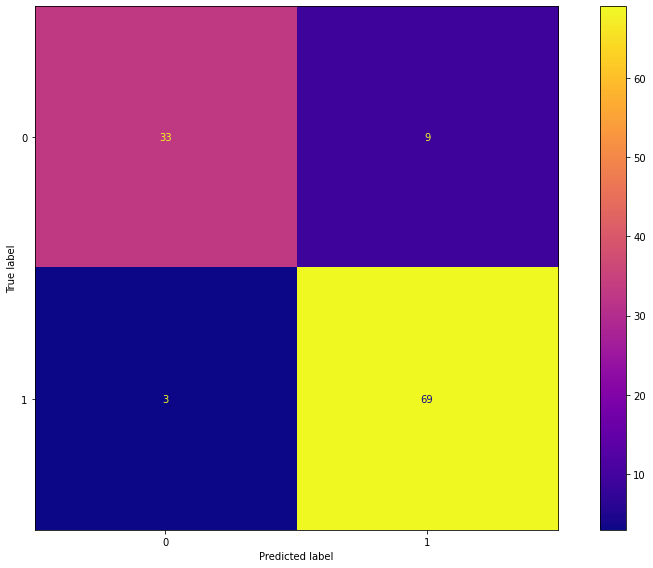

In [112]:
# build LDA model
lda.fit(X_train, y_train)

# predict
y_pred =lda.predict(X_test)

# show results
print(classification_report(y_test, y_pred))

mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=lda.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()



***********

[Return to Table of Contents](#TableOfContents)

## Cancern dataset all features

In [113]:
# let us split the whole data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(cancer_pd, labels, test_size=0.2, stratify=labels, random_state=20)


Execution time: 0.01 minutes
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



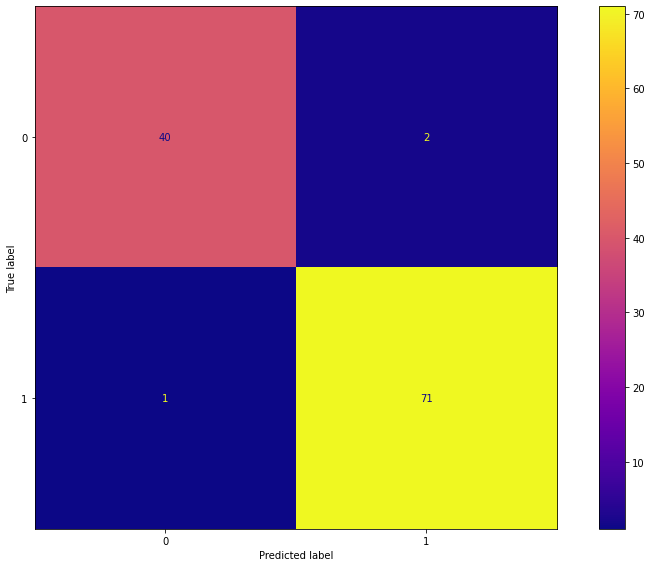

In [114]:

# values to finetune svm
Cs     = [0.1, 0.5, 1 ]
gms    = [10, 30, 'auto', 'scale' ]

# dict parameters
param = {'C': Cs, 'gamma': gms, 'kernel': ['rbf']}

# instantiate the gridsearch method ( estimator, param, cv, scoring )
svmModel = GridSearchCV(SVC(), param_grid = param, cv=5, scoring='accuracy')

mnmx = MinMaxScaler().fit(X_train)

start = time.time() 
svmModel.fit(mnmx.transform(X_train), y_train)
end = time.time()

#Execution time
total_time = end - start
print("Execution time: %0.2f minutes"%(total_time/60.0))


# report the results using testing data
y_pred = svmModel.predict(mnmx.transform(X_test))
print(classification_report(y_test, y_pred))


mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=lda.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()



              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



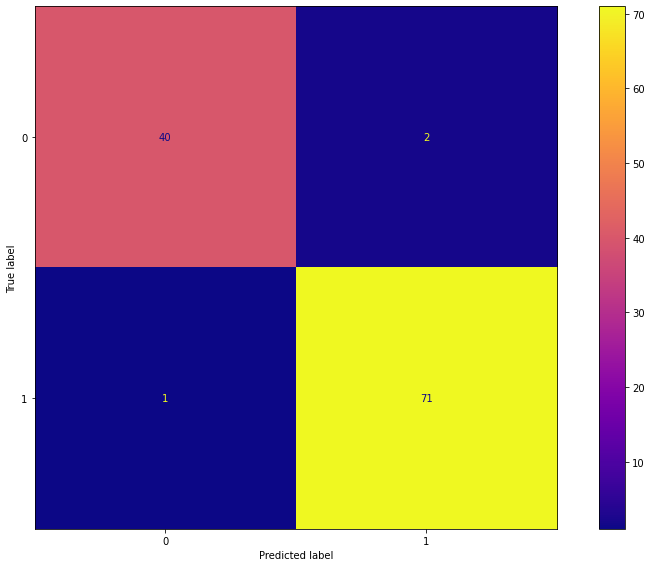

In [115]:
# let us use higher features using a transformer and report the classification above
# instantiate a model 
modelLg = make_pipeline(PowerTransformer(), LogisticRegression( ))

# train the model
modelLg.fit(X_train.values, y_train)

# report the results using testing data
y_pred = modelLg.predict(X_test.values)

print(classification_report(y_test, y_pred))

mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=lda.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()


              precision    recall  f1-score   support

           0       1.00      0.86      0.92        42
           1       0.92      1.00      0.96        72

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



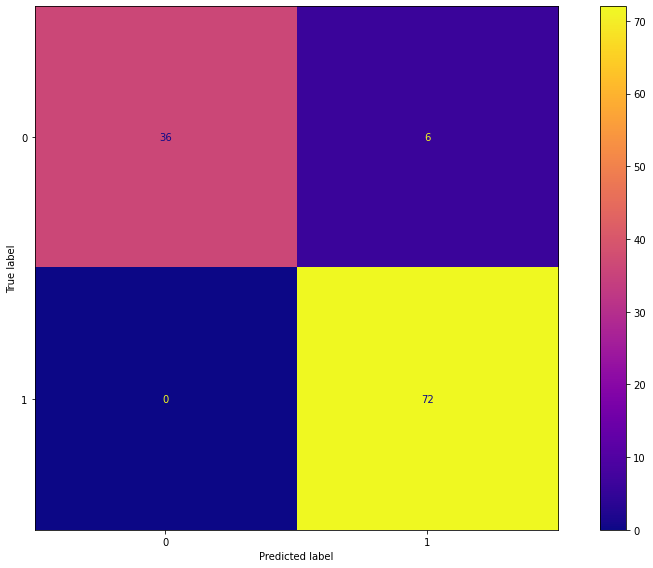

In [116]:
# build LDA model
lda.fit(X_train, y_train)

# predict
y_pred =lda.predict(X_test)

# show results
print(classification_report(y_test, y_pred))

mtConf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mtConf, display_labels=lda.classes_)
disp.plot(cmap='plasma')
plt.tight_layout(rect=(0,0,2,2))
plt.show()



************

[TOP](#TableOfContents)

[Current SKlearn (V 1.1.0) Documentation](https://scikit-learn.org/stable/user_guide.html)